In [1]:
import pandas as pd
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Dirichlet, Uniform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
def plot_ratio_with_mc_error(df, num_trials, numerator_col, denominator_col):
    """
    Plot ratio of two columns from a DataFrame with Monte Carlo error bars.

    Parameters:
    - df: pandas DataFrame containing the data
    - num_trials: int, number of Monte Carlo trials (used for estimating error bars)
    - numerator_col: str, name of the column to use as numerator
    - denominator_col: str, name of the column to use as denominator
    """
    ratio_col = "var_to_bound_ratio"
    error_col = "mc_std_err"

    # Compute ratio and standard error
    df[ratio_col] = df[numerator_col] / df[denominator_col]
    df[error_col] = df[ratio_col] / np.sqrt(num_trials)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.errorbar(df["n"], df[ratio_col], yerr=df[error_col],
                 fmt='o-', capsize=4, label=f"{numerator_col} / {denominator_col}")
    plt.axhline(1.0, color='gray', linestyle='--', label='Ratio = 1')
    plt.xlabel("Sample Size (n)")
    plt.ylabel("Ratio")
    plt.title("Ratio with Monte Carlo Error Bars")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
def plot_cov_ratio_with_errorbars(
    df,
    num_trials,
    x_col='n',
    dim_col='dim',
    est_col='empirical_cov_diag',
    lb_col='empirical_cov_CI_lb',
    ub_col='empirical_cov_CI_ub',
    ref_col='inv_Curved_FI_diag',
    ylabel='Estimated / Reference',
    title= 'Ratio of Estimate to Reference with Error Bars'
):
    """
    Plot ratio of `est_col` to `ref_col` with asymmetric error bars from `lb_col` and `ub_col`.
    Grouped by `dim_col`, x-axis is `x_col`.

    Parameters:
    - df : pandas DataFrame
    - x_col : column name for x-axis (typically sample size)
    - dim_col : column name for grouping variable (e.g., dimension index)
    - est_col : column name for point estimates
    - lb_col : column name for CI lower bound
    - ub_col : column name for CI upper bound
    - ref_col : column name for reference baseline (e.g., inverse FI diagonal)
    - ylabel : label for y-axis
    - title : plot title
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    grouped = df.groupby(dim_col)

    for dim, group in grouped:
        x_vals = group[x_col]
        ref_vals = group[ref_col]
        ratio = group[est_col] / ref_vals
        err_lower = (group[est_col] - group[lb_col]) / ref_vals
        err_upper = (group[ub_col] - group[est_col]) / ref_vals
        yerr = [err_lower.values, err_upper.values]

        ax.errorbar(
            x_vals, ratio, yerr=yerr,
            label=f'{dim_col} = {dim}',
            capsize=4, marker='o', linestyle='-'
        )

    title += f", {num_trials} Monte Carlo Trials"
    # ax.axhline(y=1.0, color='gray', linestyle='--', label='Ratio = 1')
    ax.set_xlabel(x_col)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


First we verify that CLT works for the linear regression problem $Y = XB + E$, where $B$ is a rotation matrix parametrized by $\theta$, and $E$ is a random matrix with i.i.d. $N(0, \sigma)$ entries. True $B$ is assumed to be $I_2$.

In particular, we want to compare the variance of $\theta$ and the predicted variance given by the curved Fisher's Information. 

In [3]:
def orthogonal_procrustes(X, Y, enforce_rotation=False):
    """
    Solves the orthogonal Procrustes problem:
        min_B || Y - X B ||_F^2
    subject to: B ∈ O_p (orthogonal matrix)
    
    Parameters:
        enforce_rotation (bool): If True, ensures det(B)=+1 (proper rotation)
        return_theta (bool): If True and B is 2x2, also return the angle θ (in radians)

    Returns:
        B (optimal orthogonal matrix)
        θ (optimal rotation angle)
    """
    M = X.T @ Y
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    B = U @ Vt

    if enforce_rotation:
        det = torch.linalg.det(B)
        if det < 0:
            Vt[-1, :] *= -1
            B = U @ Vt


    if B.shape != (2, 2):
        raise ValueError("return_theta=True is only supported for 2x2 matrices.")
    theta = torch.atan2(B[1, 0], B[0, 0])  # atan2(sinθ, cosθ)
    return B, theta

def rotation_matrix(theta):
    
    c, s = torch.cos(theta), torch.sin(theta)
    B =  torch.stack([
        torch.stack([c, -s]),
        torch.stack([s,  c])
    ])
    
    return B
    
def Curved_FI_rotation_lin_reg(X, sigma, theta):
    
    theta = torch.tensor(theta, dtype=X.dtype)
    c, s = torch.cos(theta), torch.sin(theta)
    B_deriv = torch.stack([
        torch.stack([-s, -c]),
        torch.stack([c,  -s])
    ])  # dB/dtheta
    I_curved = (1 / sigma**2) * torch.norm(X @ B_deriv, p = 'fro')**2
    
    return I_curved

def gen_Y(X, sigma, true_theta = 0, device = device):
    
    n, p = X.shape
    true_theta = torch.tensor(true_theta, dtype=X.dtype)
    normal = Normal(0, sigma)
    
    B = rotation_matrix(true_theta).to(device)
    noise = normal.sample((n, p)).to(device)
    Y = X @ B + noise
    return(Y)

In [ ]:
def rotation_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma = 0.02, true_theta = 0):
    unif = Uniform(0, 1)
    var_list = []
    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, 2))
        Curved_FI = Curved_FI_rotation_lin_reg(X, sigma, true_theta)
        theta_hat_list = []
        for _ in range(num_trials):
            Y = gen_Y(X, sigma, true_theta)
            B_hat, theta_hat = orthogonal_procrustes(X, Y, True)
            theta_hat_list.append(theta_hat)
        theta_var = {"n": n, 
                     "num_trials": torch.tensor(theta_hat_list).var().item(),
                     "inv_Curved_FI": (1/Curved_FI).item()}
        var_list.append(theta_var)
    
    df = pd.DataFrame(var_list)
    return(df)
            


In [172]:
num_trials = 10000
df_rotation = rotation_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

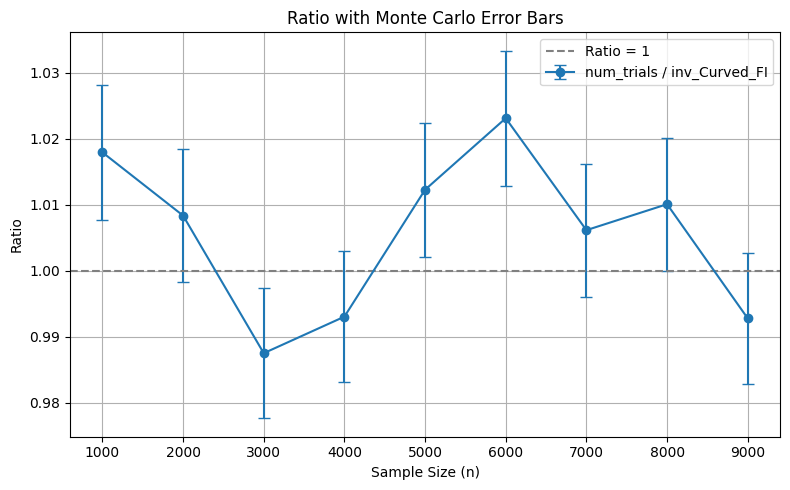

In [173]:
plot_ratio_with_mc_error(df_rotation, num_trials, "num_trials" , "inv_Curved_FI")

Now we move on to the same regression problem, but $B \in O_p$ instead of the rotation matrix constraint. $B$ can still be solved the same way, but due to the lack of parametrization, we have to replace the Jacobian of $B(\theta)$ with a matrix whose columns are orthonormal bases of $T_I(O_p)$ (since we are assuming that $B = I_2$).

In [5]:
def skew_symmetric_basis(p):
    """
    Returns a matrix whose columns are the vectorized orthonormal basis elements
    of the space of p x p skew-symmetric matrices.

    Output shape: (p^2, d), where d = p(p-1)/2
    """
    basis_list = []
    for i in range(p):
        for j in range(i+1, p):
            E = torch.zeros((p, p))
            E[i, j] = 1 / torch.sqrt(torch.tensor(2.0))
            E[j, i] = -1 / torch.sqrt(torch.tensor(2.0))
            basis_list.append(E.reshape(-1))  # vectorize

    basis_matrix = torch.stack(basis_list, dim=1)  # shape (p^2, d)
    return basis_matrix


def project_to_tangent_space(Delta, basis_matrix):
    """
    Project a matrix Delta onto the tangent space spanned by an orthonormal basis.
    
    Parameters:
        Delta         : (p x p) matrix of deviations (e.g., W_hat - I)
        basis_matrix  : (p^2 x d) matrix, each column is a vectorized orthonormal basis element of T_I(O_p)
    
    Returns:
        projection    : (p x p) matrix, projection of Delta into tangent space
        coeffs        : (d,) tensor, coefficients of Delta along each basis direction
    """
    basis_matrix = basis_matrix.to(device)
    p_squared, d = basis_matrix.shape
    Delta_vec = Delta.to(device).reshape(-1)                 # shape (p^2,)
    coeffs = basis_matrix.T @ Delta_vec           # shape (d,)
    projection_vec = basis_matrix @ coeffs        # shape (p^2,)
    projection_matrix = projection_vec.reshape(Delta.shape)  # shape (p x p)
    
    return projection_matrix, coeffs

def Curved_FI_Op_lin_reg(X, sigma, device = device):
    """
    Compute curved Fisher Information matrix for orthogonally constrained regression model.
    
    Parameters:
        X     : (n x p) design matrix
        sigma : noise std deviation

    Returns:
        FI_curved : (d x d) Fisher Information projected onto skew-symmetric tangent space
    """
    n, p = X.shape
    basis_mat = skew_symmetric_basis(p).to(device)  # (p^2 x d)
    
    FI_full = (1 / sigma**2) * torch.kron(torch.eye(p, device = device), X.T @ X)  # (p^2 x p^2)
    FI_curved = basis_mat.T @ FI_full @ basis_mat                 # (d x d)
    
    return FI_curved


def compute_empirical_cov(coeff_matrix, ci_lower=2.5, ci_upper=97.5, num_bootstrap=1000, seed=None):
    """
    Computes:
    - Unbiased empirical covariance matrix from coeff_matrix (num_trials x d)
    - Bootstrap confidence interval per entry using resampling

    Returns:
    - cov: empirical covariance matrix (d x d)
    - ci_lower_mat: lower bound matrix (d x d)
    - ci_upper_mat: upper bound matrix (d x d)
    """
    if seed is not None:
        torch.manual_seed(seed)

    num_trials, d = coeff_matrix.shape
    device = coeff_matrix.device

    # Empirical covariance (unbiased)
    mean = coeff_matrix.mean(dim=0, keepdim=True)
    centered = coeff_matrix - mean
    cov = (centered.T @ centered) / (num_trials - 1)

    # Bootstrap estimates
    boot_covs = []
    for _ in range(num_bootstrap):
        indices = torch.randint(0, num_trials, (num_trials,), device=device)
        sample = coeff_matrix[indices]
        sample_mean = sample.mean(dim=0, keepdim=True)
        sample_centered = sample - sample_mean
        cov_sample = (sample_centered.T @ sample_centered) / (num_trials - 1)
        boot_covs.append(cov_sample.unsqueeze(0))

    boot_covs = torch.cat(boot_covs, dim=0)  # shape: (num_bootstrap, d, d)

    ci_lower_mat = torch.quantile(boot_covs, ci_lower / 100.0, dim=0)
    ci_upper_mat = torch.quantile(boot_covs, ci_upper / 100.0, dim=0)

    return cov, ci_lower_mat, ci_upper_mat


def Op_reg_variance_simulation(num_trials, n_min, n_max, n_step_size, sigma=0.02, p=2):
    unif = Uniform(0, 1)
    var_list = []

    for n in range(n_min, n_max, n_step_size):
        X = unif.sample((n, p)).to(device)
        FI_curved = Curved_FI_Op_lin_reg(X, sigma).to(device)
        basis_mat = skew_symmetric_basis(p)

        coeff_matrix = []

        for _ in range(num_trials):
            sys.stdout.write(f"\rCurrently at {(_ / num_trials * 100):.2f}% for n = {n}.    ")
            sys.stdout.flush()
            Y = gen_Y(X, sigma)  # assumes default true_W = identity
            W_hat = orthogonal_procrustes(X, Y, enforce_rotation=False)[0]  # full O(p), not just rotation
            Delta = W_hat - torch.eye(p, device=device)
            _, coeffs = project_to_tangent_space(Delta, basis_mat)
            coeff_matrix.append(coeffs)

        coeff_matrix = torch.stack(coeff_matrix, dim=0)  # shape (num_trials x d)
        empirical_cov, lb, ub = compute_empirical_cov(coeff_matrix)  # (d x d)
        
        inv_FI_diag = torch.linalg.inv(FI_curved).diag()
        cov_diag = empirical_cov.diag()
        lb_diag = lb.diag()
        ub_diag = ub.diag()

        for i in range(len(cov_diag)):
            var_record = {
                "n": n,
                "dim": i,
                "empirical_cov_diag": cov_diag[i].item(),
                "empirical_cov_CI_lb": lb_diag[i].item(),
                "empirical_cov_CI_ub": ub_diag[i].item(),
                "inv_Curved_FI_diag": inv_FI_diag[i].item()
            }
            var_list.append(var_record)

    df = pd.DataFrame(var_list)
    return df

In [92]:
num_trials = 10000
df_Op = Op_reg_variance_simulation(num_trials = num_trials, 
                                      n_min = 1000, 
                                      n_max = 10000, 
                                      n_step_size = 1000)

Currently at 99.99% for n = 9000.    

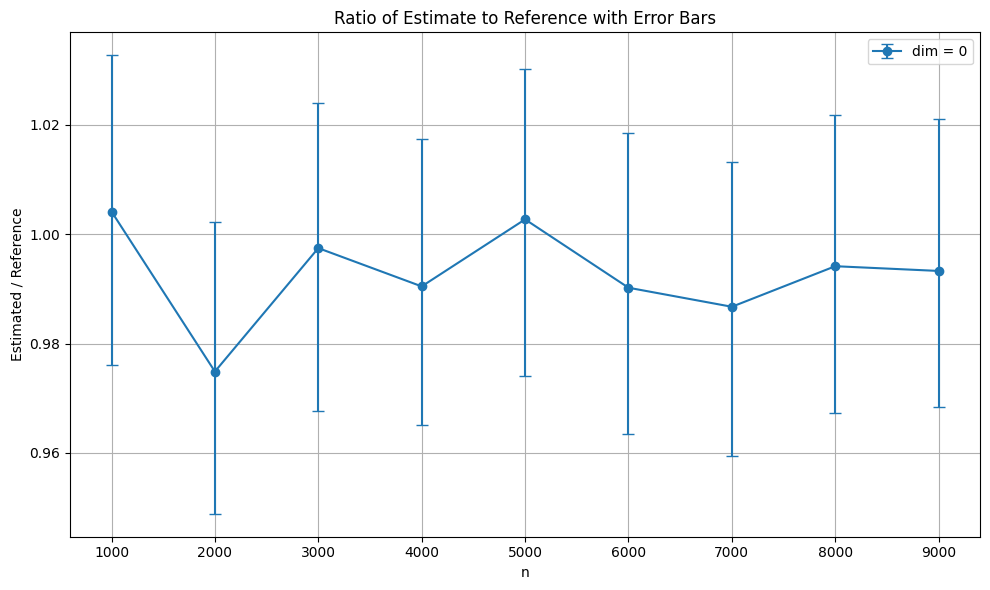

In [94]:
plot_cov_ratio_with_errorbars(df_Op)